#### 현 상황
CVXPY 사용시 DCP 오류가 발생함. 
DCP 오류는 목적함수가 Convex 함수가 아닐 때 발생하는 것이나, 

> $L_D = \frac{-1}{2} \sum_{i,j=1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)x_i^Tx_j - \epsilon\sum_{i,j=1}^n(\alpha_i + \alpha_i^*) + \sum_{i,j=1}^n y_i(\alpha_i^* - \alpha_i)$ 

$L_D$는 
> let $\alpha_i^* - \alpha_i = t_i$. 
> obj : $ -\frac{1}{2}t * K * t.T + y * t.T -\epsilon * t.T + \epsilon * \alpha $

처럼 2개의 독립변수(t, $\alpha$)로 구성된 convex 함수로 표현할 수 있어 오류의 원인이 무엇인지 확인이 어려운 상태다. 

이에 DSBA 이지윤님이 정리하신 코드를 적용해보았으나, 동일한 DCP 문제가 발생한다. 
- 출처 : https://leejiyoon52.github.io/Support-Vecter-Regression/

cvs 모듈에 대한 좀 더 깊은 이해가 필요할 것으로 보이는 바, 추후 복기할 때 재 시도를 해보겠다. 


# Kernel Learning - SVR 

1. 최적화 문제 정의 

2. 라그랑주 승수법을 통해서 라그랑주 목적 함수로 변환 


3. 목적함수를 듀얼 함수로 변경하여 답 찾기 
> $L_D = \frac{-1}{2} \sum_{i,j=1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)x_i^Tx_j - \epsilon\sum_{i,j=1}^n(\alpha_i + \alpha_i^*) + \sum_{i,j=1}^n y_i(\alpha_i^* - \alpha_i)$ 
- Convex probelm solve package인 CVXPY를 통해서 $\alpha_i, \alpha_i^*$ 에 대한 해 찾기

4. 커널 트릭을 도입한다. 

--- 

**실제로 구현할 것**
1. 다양한 커널 함수에 따라 서로 다른 결과값이 나올 수 있도록 할 것. 
2. CVXPY 모듈을 통한 듀얼함수의 해 찾기 
3. 구한 $\alpha_i, \alpha_i^*$ 를 통해서 w, b, f(x)의 값 찾기 


**해결해야하는 점**
- 변수가 2개가 주어지는 상황에서의 Convex 문제의 해를 어떻게 찾을 것인가? 



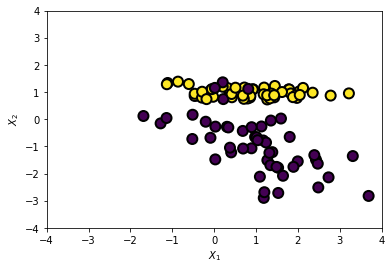

In [9]:
# 데이터 사용 및 라이브러리 설치 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification 

X, y = make_classification(n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=0)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=100, edgecolor="k", linewidth=2)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

### __init__ 함수 정의와 다양한 커널함수 적용하기 

**구현해야하는 것** 
1. 커널함수 
- Polynomial : $K(x_i,x_j) = (x_i*x_j)^d, c>0$ 
- Gaussian(RBF) : $K(x_i,x_j) = exp(-\frac{||x_i-x_j||^2}{2\sigma^2}, \sigma \neq 0$ 
- Sigmoid : $K(x_i,x_j) = tanh(a(x_i*x_j) + b), a,b >- 0 $

**필요한 것**
- xi, x_j 
- 커널함수를 지정하는 값 ("poly", "RBF", "sig") 

**함수의 형태**
- def __init__(self, X,y,c, kernel_type)

- def kernel_fn(self, x_i, x_j, kernel, coef, degree, gamma) : => 커널함수 값으로 반환 

- def kernel_matrix(self, X, kernel) : => ij 자리에 $ K(x_i, x_j)$ 값을 가진 n x n 행렬 반환   

In [22]:
class SVR() : 
    def __init__(self, X, y, c, epsilon, kernel_type) : 
        self.X = X
        self.n = np.shape(X)[0]
        self.m = np.shape(X)[1]
        
        self.y = y
        self.c = c
        self.epsilon = epsilon
        self.kernel_type = kernel_type
        self.k_matrix = self.kernel_matrix()
        
    def kernel_fn(self, x_i, x_j, kernel = None, coef = 1.0, degree = 3, gamma = 0.1) : 
        if kernel == "poly" : 
            return (np.dot(x_i, x_j) + coef)** degree 
        
        elif kernel == "RBF" : 
            return np.exp(- np.sum(np.square(x_i - x_j)) * gamma)
        
        elif kernel == "sig" : 
            return np.tanh(np.dot(x_i, x_j) + coef) 
        
        else : 
            return np.dot(x_i, x_j) 
        
    
    def kernel_matrix(self) : 
        k_matrix = np.zeros((self.n, self.n))
        for i in range(self.n) : 
            for j in range(self.n) : 
                k_matrix[i,j] = self.kernel_fn(self.X[i], self.X[j], self.kernel_type)
        return k_matrix
                

In [23]:
test = SVR(X,y, 3, 3, "")
print(test.kernel_matrix())

[[1.27945473e-05 2.64791823e-04 4.77625432e-04 ... 3.49777540e-02
  3.50186573e-02 3.53316438e-02]
 [2.64791823e-04 5.48004614e-03 9.88478185e-03 ... 7.23888312e-01
  7.24734834e-01 7.31212301e-01]
 [4.77625432e-04 9.88478185e-03 1.78299433e-02 ... 1.30573318e+00
  1.30726011e+00 1.31894402e+00]
 ...
 [3.49777540e-02 7.23888312e-01 1.30573318e+00 ... 9.56222402e+01
  9.57340617e+01 9.65897046e+01]
 [3.50186573e-02 7.24734834e-01 1.30726011e+00 ... 9.57340617e+01
  9.58460141e+01 9.67026575e+01]
 [3.53316438e-02 7.31212301e-01 1.31894402e+00 ... 9.65897046e+01
  9.67026575e+01 9.75669574e+01]]


### 2. CVXPY 모듈을 통한 듀얼함수의 해 찾기

**구현해야하는 것** 
1. CVX 모듈을 통해 max($L_D$)의 해 찾기 
- $L_D = \frac{-1}{2} \sum_{i,j=1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)x_i^Tx_j - \epsilon\sum_{i,j=1}^n(\alpha_i + \alpha_i^*) + \sum_{i,j=1}^n y_i(\alpha_i^* - \alpha_i)$ 


**필요한 것**
- obj : 최소/ 최대값을 찾고자 하는 함수 

> $\frac{-1}{2} \sum_{i,j=1}^n (\alpha_i^* - \alpha_i)(\alpha_j^* - \alpha_j)K(x_i)^TK(x_j) - \epsilon\sum_{i,j=1}^n(\alpha_i + \alpha_i^*) + \sum_{i,j=1}^n y_i(\alpha_i^* - \alpha_i)$  

> let $\alpha_i^* - \alpha_i = t_i$. 

> obj : $ -\frac{1}{2}t * K * t.T + y * t.T -\epsilon * t.T + \epsilon * \alpha $

- const : 제약식 

> $\sum t = 0$

> $t_i \in [-C, C], \alpha_i \in [0, C]$

- problem = cvx.Problem(obj, const)
- result = prob.solve 



**함수의 형태**
- def __init__(self, X,y,c, kernel_type)

- def find_alpha(self) : => $\alpha^*, \alpha$ 값 반환 


In [40]:
#DCP 오류 발생. obj 가 convex 함수가 아니라고 함. 흠.. 어떻게 해결해야 하나

class SVR() : 
    def __init__(self, X, y, c, epsilon, kernel_type) : 
        self.X = X
        self.n = np.shape(X)[0]
        self.m = np.shape(X)[1]
        
        self.y = y
        self.c = c
        self.epsilon = epsilon
        self.kernel_type = kernel_type
        self.k_matrix = self.kernel_matrix()
        
    def kernel_fn(self, x_i, x_j, kernel = None, coef = 1.0, degree = 3, gamma = 0.1) : 
        if kernel == "poly" : 
            return (np.dot(x_i, x_j) + coef)** degree 
        
        elif kernel == "RBF" : 
            return np.exp(- np.sum(np.square(x_i - x_j)) * gamma)
        
        elif kernel == "sig" : 
            return np.tanh(np.dot(x_i, x_j) + coef) 
        
        else : 
            return np.dot(x_i, x_j) 
        
    
    def kernel_matrix(self) : 
        k_matrix = np.zeros((self.n, self.n))
        for i in range(self.n) : 
            for j in range(self.n) : 
                k_matrix[i,j] = self.kernel_fn(self.X[i], self.X[j], self.kernel_type)
        return k_matrix
                
    def find_alpha(self) : 
        t = cvx.Variable(self.n) # t = alpha_* - alpha
        alpha = cvx.Variable(self.n)

        """
        cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix()) 
             - self.epsilon*one_vec*(alpha+alpha_) 
             + self.y*(alpha-alpha_))
        """
        
        obj = cvx.Maximize(-0.5*cvx.quad_form(t, self.k_matrix) + self.epsilon*np.ones(self.n)*(-t + 2*alpha) + self.y*t) 
        const = [cvx.sum(t) == 0 ]
        for i in range(self.n) : 
            const += [t[i] >= -self.c, alpha[i] >=0]
            const += [t[i] <= self.c, alpha[i] <= self.c]
        svr = cvx.Problem(obj, const)
        svr.solve()
        
        t = np.array(t.value).flatten()
        alpha = np.array(alpha.value).flatten() 
        alpha_ = t + alpha
        
        return alpha_, alpha
        

In [56]:
test = SVR(X,y, 3, 3, "")
b = test.find_alpha()

print(np.shape(b))

C:\Users\PC\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 11 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\PC\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 12 times so far.

  warnings.warn(msg, UserWarning)


DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var7322, [[1.27945473e-05 2.64791823e-04 4.77625432e-04 ... 3.49777540e-02
  3.50186573e-02 3.53316438e-02]
 [2.64791823e-04 5.48004614e-03 9.88478185e-03 ... 7.23888312e-01
  7.24734834e-01 7.31212301e-01]
 [4.77625432e-04 9.88478185e-03 1.78299433e-02 ... 1.30573318e+00
  1.30726011e+00 1.31894402e+00]
 ...
 [3.49777540e-02 7.23888312e-01 1.30573318e+00 ... 9.56222402e+01
  9.57340617e+01 9.65897046e+01]
 [3.50186573e-02 7.24734834e-01 1.30726011e+00 ... 9.57340617e+01
  9.58460141e+01 9.67026575e+01]
 [3.53316438e-02 7.31212301e-01 1.31894402e+00 ... 9.65897046e+01
  9.67026575e+01 9.75669574e+01]])

In [57]:
np.shape(b)

NameError: name 'b' is not defined

In [2]:
def kernel_f(xi, xj, kernel = None, coef0=1.0, degree=3, gamma=0.1):

    if kernel == 'linear':                                  # Linear kernel
        result = np.dot(xi,xj)+coef0
    elif kernel == 'poly':                                  # Polynomial kernel
        result = (np.dot(xi,xj)+coef0)**degree
    elif kernel == 'rbf':                                   # RBF kernel
        result = np.exp(-gamma*np.linalg.norm(xi-xj)**2)
    elif kernel =='sigmoid':                                # Sigmoid kernel
        result = np.tanh(gamma*np.dot(xi,xj)+coef0)
    else:                                                   # Dot product
        result = np.dot(xi,xj)

    return result

In [5]:
def kernel_matrix(X, kernel, coef0=1.0, degree=3, gamma=0.1):

    X = np.array(X,dtype=np.float64)
    mat = []
    for i in X:
        row = []
        for j in X:
            if kernel=='linear':           
                row.append(kernel_f(i, j,'linear', coef0))   
            elif kernel=='poly':
                row.append(kernel_f(i, j,'poly', coef0, degree))
            elif kernel=='rbf':
                row.append(kernel_f(i,j,'rbf', gamma))
            elif kernel =='sigmoid':
                row.append(kernel_f(i,j,'sigmoid', coef0, gamma))    
            else:
                row.append(np.dot(i,j))
        mat.append(row)

    return mat

In [6]:
## Epsilon - insensitive loss
def eps_loss(t, c=3, e = 5):
    return(abs(t)<e)*0* abs(t) +((t)>=e)*c*abs(t-e) +((t)<-e)*c*abs(t+e)

In [7]:
## Laplacian loss
def laplacian_loss(t, c=3):
    return c*abs(t)

In [8]:
## Gaussian loss
def gaussian_loss(t, c=3):
    return c*0.5*t**2   

In [9]:
## Hubor loss
def huber_loss(t, c=3, s=5):
    return c*((abs(t)<s)*(0.5/s)*(t**2) + (abs(t)>=s)*(abs(t)-s/2))

In [10]:
# Polynomial loss
def poly_loss(t, c=3, p=3):
    return c*((p**-1)*abs(t)**p)

In [11]:
## Piecewise polynomial
def Picewise_polynomial_loss(t, c=3, s=5, p=3):
    return c*((abs(t)<=s)*((abs(t)**p)/p/(s*(p-1)))+(abs(t)>s)*(abs(t)-(s*(p-1))/p))  

In [12]:
## Quadratic form
class svr:
    '''
    loss: ['epsilon-insensitive','huber','laplacian','gaussian','polynomial','piecewise_polynomial'] defualt: epsilon-insensitive
    kernel: [None,'rbf', 'linear','poly']
    coef0: Independent term in kernel function. in 'linear','poly'
    degree: Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
    gamma: Kernel coefficient for ‘rbf’, ‘poly’
    p: polynomial/'piecewise_polynomial loss function p
    sigma: for loss function
    '''
    def __init__(self,loss = 'epsilon-insensitive',C = 1.0, epsilon = 1.0,
                 kernel = None, coef0=1.0, degree=3, gamma=0.1, p=3, sigma=0.1):
        self.loss = loss
        self.kernel = kernel
        self.C = C
        self.epsilon = epsilon
        self.coef0 = coef0
        self.degree= degree
        self.gamma = gamma
        self.sigma = sigma
        self.p = p

    #model fitting    
    def fit(self,X,y):
        self.X = X
        self.y = y

        n = self.X.shape[0]#numper of instances
        #variable for dual optimization problem

        alpha = cvx.Variable(n)
        alpha_ = cvx.Variable(n)
        one_vec = np.ones(n)

        #object function and constraints of all types of loss fuction

        if self.loss == 'huber':
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) - self.epsilon*one_vec*(alpha+alpha_) + self.y*(alpha-alpha_) - self.sigma/(2*self.C)*one_vec*(cvx.power(alpha, 2) + cvx.power(alpha_, 2)))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i],
                                       kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'laplacian': # epsilon = 0 of epsilon-insensitive
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_,
                                                     kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) + self.y*(alpha-alpha_))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0, alpha[i] <= self.C, alpha_[i] <= self.C]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i],
                                       kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'gaussian': # sigma = 1 of huber
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_,
                                                     kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) - self.epsilon*one_vec*(alpha+alpha_) + self.y*(alpha-alpha_) - 1./(2*self.C)*one_vec*(cvx.power(alpha, 2) + cvx.power(alpha_, 2)))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i],
                                       kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'polynomial':
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_,
                                                     kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) + self.y*(alpha-alpha_) - (self.p-1)/(self.p*self.C**(self.p-1))* one_vec*(cvx.power(alpha, self.p/(self.p-1)) + cvx.power(alpha_, self.p/(self.p-1))))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i],
                                       kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])

        elif self.loss == 'piecewise_polynomial':
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_,
                                                     kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) + self.y*(alpha-alpha_) - (self.p-1)*self.sigma/(self.p*self.C**(self.p-1))* one_vec*(cvx.power(alpha, self.p/(self.p-1)) + cvx.power(alpha_, self.p/(self.p-1))))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i],
                                       kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])
        else:
            self.constraints = []
            self.svr_obj = cvx.Maximize(-.5*cvx.quad_form(alpha-alpha_, kernel_matrix(self.X,kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma)) - self.epsilon*one_vec*(alpha+alpha_) + self.y*(alpha-alpha_))
            self.constraints += [cvx.sum(one_vec*alpha - one_vec*alpha_) == 0]
            for i in range(n):
                self.constraints += [alpha[i] >= 0, alpha_[i] >=0, alpha[i] <= self.C, alpha_[i] <= self.C]
            svr = cvx.Problem(self.svr_obj,self.constraints)
            svr.solve()

            #alpha & alpha_
            self.a = np.array(alpha.value).flatten()
            self.a_ = np.array(alpha_.value).flatten()

            #compute b
            idx = np.where((np.array(alpha.value).ravel() < self.C-1E-10) * (np.array(alpha.value).ravel() > 1E-10))[0][0]
            self.b = -self.epsilon + self.y[idx] - np.sum([(alpha.value[i]-alpha_.value[i])*kernel_f(self.X[idx], self.X[i],
                                       kernel=self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)])


    def predict(self,new_X):
        self.results = []
        n = new_X.shape[0]
        for j in range(n):
            X = new_X[j]
            self.results += [np.sum([(self.a[i] - self.a_[i]) *kernel_f(X, self.X[i],
                                     kernel = self.kernel,coef0=self.coef0,degree=self.degree,gamma=self.gamma) for i in range(n)]) + self.b]   
        return self.results

In [13]:
test = svr()
test.fit(X,y)


C:\Users\PC\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\PC\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:564: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning)
C:\Users\PC\anaconda3\lib\

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
QuadForm(var0 + -var1, [[3.27156985e-04 9.29617231e-04 7.25832170e-03 ... 1.75676137e-01
  1.77348444e-01 1.78967963e-01]
 [9.29617231e-04 2.64150923e-03 2.06245357e-02 ... 4.99184097e-01
  5.03935961e-01 5.08537827e-01]
 [7.25832170e-03 2.06245357e-02 1.61033499e-01 ... 3.89755982e+00
  3.93466171e+00 3.97059244e+00]
 ...
 [1.75676137e-01 4.99184097e-01 3.89755982e+00 ... 9.43342389e+01
  9.52322312e+01 9.61018774e+01]
 [1.77348444e-01 5.03935961e-01 3.93466171e+00 ... 9.52322312e+01
  9.61387718e+01 9.70166963e+01]
 [1.78967963e-01 5.08537827e-01 3.97059244e+00 ... 9.61018774e+01
  9.70166963e+01 9.79026379e+01]])